In [85]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

import sys
sys.path.insert(1, '/kaggle/input/quadrule')

from GaussJacobiQuadRule_V3 import Jacobi, DJacobi, GaussLobattoJacobiWeights, GaussJacobiWeights
import time
import os

import random 

from scipy.integrate import quad
from math import sqrt


#notes:
#remove all persistent==true can slow down the code
#maybe is not the best use to save in memory all the traslated elem elements,just save all the test fuction and the derivatives of the test functions
#two different inits,implemented
#maybe use diff quad rules,for istance quadpy
#



![](poisson.png)

![](poisson_example.png)

In [86]:
class VPINN(tf.keras.Model):

    def __init__(self, pb, params,seed,NN):

        super().__init__()

        # accept parameters
        self.pb = pb
        self.params = params
        self.SEED=seed

        # generate all precomp stuff
        self.generate_boundary_points()
        self.generate_inner_points()
        self.generate_quadrature_points()
        self.construct_RHS()

        # add the neural network to the class if given at initialisation
        if NN:
            self.set_NN(NN)
        else: 
            self.NN=self.initialize_NN()
            self.vars = self.NN.trainable_variables
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.params['LR'])

    def custom_call(self,x):
        input=tf.constant([x],dtype=tf.float64)
        output=self.NN(input)
        return output.numpy().item()

    def set_NN(self, NN, LR):
        np.random.seed(self.SEED)
        tf.random.set_seed(self.SEED)
        # initialise the NN
        self.NN = NN

        # take trainable vars
        self.vars = self.NN.trainable_variables

        # set optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

    def initialize_NN(self):

        NN = tf.keras.Sequential()
        NN.add(tf.keras.layers.InputLayer(self.params['NN_struct'][0],dtype=tf.float64))
        # NN.add(tf.keras.layers.Lambda(lambda x: 2. * (x + 1) / (2) - 1.))

        for width in self.params['NN_struct'][1:-1]:
            NN.add(tf.keras.layers.Dense(width,
                                            activation=tf.math.sin,
                                            use_bias=True,
                                            kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED),
                                            bias_initializer='zeros',dtype=tf.float64))
        NN.add(tf.keras.layers.Dense(self.params['NN_struct'][-1], activation='linear',dtype=tf.float64,kernel_initializer=tf.keras.initializers.GlorotUniform(self.SEED)))

        return NN


    def eval_NN(self, x):
        x = tf.convert_to_tensor(x, dtype=tf.float64)        

        with tf.GradientTape() as second_order:
            second_order.watch(x)
            with tf.GradientTape() as first_order:
                first_order.watch(x)
                u = self.NN(x)
            d1xu = first_order.gradient(u, x)
        d2xu = second_order.gradient(d1xu, x)

        del first_order
        del second_order

        return u, d1xu, d2xu

    def boundary_loss(self):
    ## NOTE:impose boundary or same structure for ICs
        u_bound_NN = self.eval_NN(self.boundary_points)[0]
        return tf.reduce_mean(tf.square(u_bound_NN - self.boundary_sol))

    def variational_loss(self):
        #TODO: general organisation
        varloss_total = 0.0
        N = self.params['n_elements']
        for el in range(N):
                
            n_test = self.params['n_test'][el]

            F_ext_element = self.F_ext_total[el]
            jacobian = self.J[el]
            x_quad_element = self.x_quad_total[el]
            v_quad_element = self.v_quad_total[el]
            dv_quad_element = self.dv_quad_total[el]
            dv_boundary_element = self.dv_boundary_total[el]
            d2v_quad_element = self.d2v_quad_total[el]


            u_NN_quad_el, d1xu_NN_quad_el, d2xu_NN_quad_el = self.eval_NN(x_quad_element)
            # dv_boundary_element, _ = self.pb.dtest_func(n_test, np.array([-1, 1]))

            if self.params['var_form'] == 0:
                u_NN_el = tf.stack([-jacobian*tf.reduce_sum(self.w_quad*d2xu_NN_quad_el*v_quad_element[i]) \
                                    for i in range(n_test)])




            elif self.params['var_form'] == 1:
                u_NN_el = tf.stack([tf.reduce_sum(self.w_quad*d1xu_NN_quad_el*dv_quad_element[i]) \
                                    for i in range(n_test)])   #it seems it this way that the test functions of the elem are scaled by the the half of the interval size,so when they are sclaed by the jacobian it cancels
                


            elif self.params['var_form'] == 2:
                u_NN_bound_el, _, _  = self.eval_NN(np.array([x_quad_element[0], x_quad_element[-1]]))
                u_NN_el = tf.stack([-1/jacobian*tf.reduce_sum(self.w_quad*u_NN_quad_el*d2v_quad_element[i]) \
                                    +1/jacobian*tf.reduce_sum(u_NN_bound_el*np.array([-dv_boundary_element[i][0], dv_boundary_element[i][-1]]))  \
                                    for i in range(n_test)])
            

            res_NN_element = u_NN_el - F_ext_element
            loss_element = tf.reduce_mean(tf.square(res_NN_element))
            varloss_total = varloss_total + loss_element*self.params['tau']


        return varloss_total

    @tf.function
    def loss_total(self):
        loss_0 = 0.0
        loss_b = self.boundary_loss()
        loss_v = self.variational_loss()
        loss_tot = loss_0 + loss_b + loss_v
        return loss_tot, loss_b, loss_v

    def loss_gradient(self):
        with tf.GradientTape() as loss_grad:
            #TODO: why is this commented?
            # loss_grad.watch(self.vars)
            loss_tot, loss_b, loss_v = self.loss_total()
        gradient = loss_grad.gradient(loss_tot, self.vars)
        return loss_tot, loss_b, loss_v, gradient

    @tf.function
    def gradient_descent(self):
        loss_tot, loss_b, loss_v, gradient = self.loss_gradient()
        self.optimizer.apply_gradients(zip(gradient, self.vars))
        return loss_tot, loss_b, loss_v

    def train(self, opt_iter):

        history = []

        start_time = time.time()
        for i in range(opt_iter):

            loss_tot, loss_b, loss_v = self.gradient_descent()

            if i % 10 == 0:
                history.append([i, loss_tot, loss_b, loss_v])


            if i % 100 == 0:
                elapsed = time.time() - start_time
                str_print = 'It: %d, Lossb: %.3e, Lossv: %.3e, Losstot:, %.3e, Time: %.2f'
                print(str_print % (i, loss_b, loss_v, loss_tot, elapsed))
                start_time = time.time()

        history = np.array(history)
        self.iterations = history[:,0]
        self.loss_tot = history[:,1]
        self.loss_b = history[:,2]
        self.loss_v = history[:,3]

        return self.loss_tot

    def get_domain_info(self):

        a = self.params['domain'][0]
        b = self.params['domain'][1]

        scale = b - a
        mid = (a + b)*0.5

        return a, b, scale, mid

    def generate_boundary_points(self):
        # Boundary points
        a, b, scale, mid = self.get_domain_info()

        self.boundary_points = np.asarray([a,b], dtype=np.float64)[:,None]
        self.boundary_sol = self.pb.u_exact(self.boundary_points)


    def generate_inner_points(self):
        _, _, scale, mid = self.get_domain_info()

        self.X_f_train = np.array(scale*(lhs(1, self.params['n_bound']) - 0.5) + mid).flatten()
        self.f_train = np.asarray(self.pb.f_exact(self.X_f_train))
        # self.f_train = ff[:, None]

    def generate_quadrature_points(self):
        [self.x_quad, self.w_quad] = GaussLobattoJacobiWeights(self.params['n_quad'], 0, 0)



    def construct_RHS(self):
        #TODO: check are the convert to tensors are needed
        N = self.params['n_elements']
        lower_bound, upper_bound, _, _ = self.get_domain_info()
        dx = (upper_bound - lower_bound)/N
        self.grid_x = np.asarray([lower_bound + i*dx for i in range(N+1)])
        n_test_funcs = self.params['n_test']

        self.U_ext_total = []
        self.F_ext_total = []
        self.J = []
        self.x_quad_total = []
        self.v_quad_total = []
        self.dv_quad_total = []
        self.dv_boundary_total = []
        self.d2v_quad_total = []

        for el_x in range(N):
            Ntest_element = n_test_funcs[el_x]

            a = self.grid_x[el_x]
            b = self.grid_x[el_x+1]

            jacobian = (b - a)/2
            x_quad_element = a + jacobian*(self.x_quad+1)

            v_quad_element = self.pb.test_func(Ntest_element, self.x_quad)        
            dv_quad_element, d2v_quad_element = self.pb.dtest_func(Ntest_element, self.x_quad)
            dv_boundary_element, _ = self.pb.dtest_func(Ntest_element, np.array([a, b]))

            u_quad_element = self.pb.u_exact(x_quad_element)
            f_quad_element = self.pb.f_exact(x_quad_element)

            U_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*u_quad_element)
                for r in range(Ntest_element)])

            F_ext_element = np.asarray([jacobian*np.sum(self.w_quad*v_quad_element[r]*f_quad_element)
                for r in range(Ntest_element)])


            self.U_ext_total.append(U_ext_element)
            self.F_ext_total.append(F_ext_element)
            self.J.append(jacobian)
            self.x_quad_total.append(x_quad_element)
            self.v_quad_total.append(v_quad_element)
            self.dv_quad_total.append(dv_quad_element)
            self.dv_boundary_total.append(dv_boundary_element)
            self.d2v_quad_total.append(d2v_quad_element)

            
        self.F_ext_total = tf.convert_to_tensor(self.F_ext_total, tf.float64)

    def generate_test_points(self):
        lower_bound, upper_bound, _, _ = self.get_domain_info()

        delta_test = self.params['delta_test']
        x_test = np.arange(lower_bound, upper_bound + delta_test, delta_test)
        data_temp = np.asarray([[x_test[i], self.pb.u_exact(x_test[i])]
                                 for i in range(len(x_test))])
    
        x_test = data_temp.flatten()[0::2]
        exact = data_temp.flatten()[1::2]
        return x_test[:, None], exact[:, None], len(x_test)
    

    def plot_loss_history(self, PLOT='SHOW'):

        font = 24
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off') 
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()
        
        fig, ax = plt.subplots()
        plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
        plt.xlabel('$iteration$', fontsize = font)
        plt.ylabel('$loss \,\, values$', fontsize = font)
        plt.yscale('log')
        plt.grid(True)
        plt.plot(self.iterations, self.loss_tot,'green',label="loss")
        plt.plot(self.iterations, self.loss_b,'blue',label="boundary_loss")
        plt.plot(self.iterations, self.loss_v, 'violet',label="variational_loss")
        plt.legend(loc="upper right")
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('VPINN_loss_history.pdf')
        else:
            plt.show()
        

    def plot_predict(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()
        prediction = self.eval_NN(x)[0]
        
        pnt_skip = 25
        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)

        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('$u$', fontsize = 24)
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, sol, linewidth=1, color='r', label=''.join(['$exact$']))
        plt.plot(x, prediction, 'k*', label='$VPINN$')
        plt.tick_params( labelsize = 20)
        legend = plt.legend(shadow=True, loc='upper left', fontsize=18, ncol = 1)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Exact.png')
        else:
            plt.show()
        
        
    def plot_pointwise_error(self, PLOT='SHOW'):

        x, sol, n_points = self.generate_test_points()

        prediction = self.eval_NN(x)[0]

        fig, ax = plt.subplots()
        plt.locator_params(axis='x', nbins=6)
        plt.locator_params(axis='y', nbins=8)
        plt.xlabel('$x$', fontsize = 24)
        plt.ylabel('point-wise error', fontsize = 24)
        plt.yscale('log')
        plt.axhline(0, linewidth=0.8, linestyle='-', color='gray')
        for xc in self.grid_x:
            plt.axvline(x=xc, linewidth=2, ls = '--')
        plt.plot(x, abs(sol - prediction), 'k')
        plt.tick_params( labelsize = 20)
        fig.set_size_inches(w=11,h=5.5)
        plt.show()

        if PLOT == 'save':
            plt.savefig('Pointwise_Error.png')
        else:
            plt.show()

In [87]:
class PROBDEF:

    def __init__(self, omega: tuple, r: int):
        self.omega = omega
        self.r = r

    def u_exact(self, x):
        utemp = 0.1*np.sin(self.omega*x) + np.tanh(self.r*x)
        return utemp

    def f_exact(self, x):
        A =  0.1*(self.omega**2)*np.sin(self.omega*x)
        B = (2*self.r**2)*(np.tanh(self.r*x))
        B /= (np.cosh(self.r*x)); B /= (np.cosh(self.r*x))
        return A + B

    @staticmethod
    def test_func_core(n, x):
        test = Jacobi(n+1, 0, 0, x) - Jacobi(n-1, 0, 0, x)
        return test

    def test_func(self, n_test, x):
        test_total = [self.test_func_core(n, x) for n in range(1, n_test+1)]
        return np.asarray(test_total)

    def dtest_func(self, n_test, x):
        n = 1
        d1test_total = [((n+2)/2)*Jacobi(n, 1, 1, x)]
        d2test_total = [((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)]
        for n in range(2, n_test+1):
            if n == 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            elif n > 2:
                d1test = ((n+2)/2)*Jacobi(n, 1, 1, x) - ((n)/2)*Jacobi(n-2, 1, 1, x)
                d2test = ((n+2)*(n+3)/(2*2))*Jacobi(n-1, 2, 2, x) - ((n)*(n+1)/(2*2))*Jacobi(n-3, 2, 2, x)
                d1test_total.append(d1test)
                d2test_total.append(d2test)
            else:
                raise ValueError("Please check the value for 'n_test'")
        return np.asarray(d1test_total), np.asarray(d2test_total)
    
    
'''
Hyper-parameters: 
    scheme     = is either 'PINNs' or 'VPINNs'
    Net_layer  = the structure of fully connected network
    var_form   = the form of the variational formulation used in VPINNs
                    0, 1, 2: no, once, twice integration-by-parts
    N_el_x, N_el_y     = number of elements in x and y direction
    N_test_x, N_test_y = number of test functions in x and y direction
    N_quad     = number of quadrature points in each direction in each element
    N_bound    = number of boundary points in the boundary loss
    N_residual = number of residual points in PINNs
'''

"\nHyper-parameters: \n    scheme     = is either 'PINNs' or 'VPINNs'\n    Net_layer  = the structure of fully connected network\n    var_form   = the form of the variational formulation used in VPINNs\n                    0, 1, 2: no, once, twice integration-by-parts\n    N_el_x, N_el_y     = number of elements in x and y direction\n    N_test_x, N_test_y = number of test functions in x and y direction\n    N_quad     = number of quadrature points in each direction in each element\n    N_bound    = number of boundary points in the boundary loss\n    N_residual = number of residual points in PINNs\n"

In [88]:
pb = PROBDEF((4*np.pi), 5)
N_tests = 60
N_elements = 1
params = {'scheme': 'VPINNs',
            'NN_struct': [1] + [5] * 1 + [1],
            'var_form': 1,
            'n_elements': N_elements,
            'n_test': N_elements*[N_tests],
            'n_quad': 100,
            'n_bound': 50,
            'n_residual': 100,
            'domain': (-1, 1),
            'Opt_Niter': 15000 + 1,
            'delta_test': 0.01,
            'LR': 0.001,
            'tau': 5.0}
print(params)

{'scheme': 'VPINNs', 'NN_struct': [1, 5, 1], 'var_form': 1, 'n_elements': 1, 'n_test': [60], 'n_quad': 100, 'n_bound': 50, 'n_residual': 100, 'domain': (-1, 1), 'Opt_Niter': 15001, 'delta_test': 0.01, 'LR': 0.001, 'tau': 5.0}


n_quad :  80


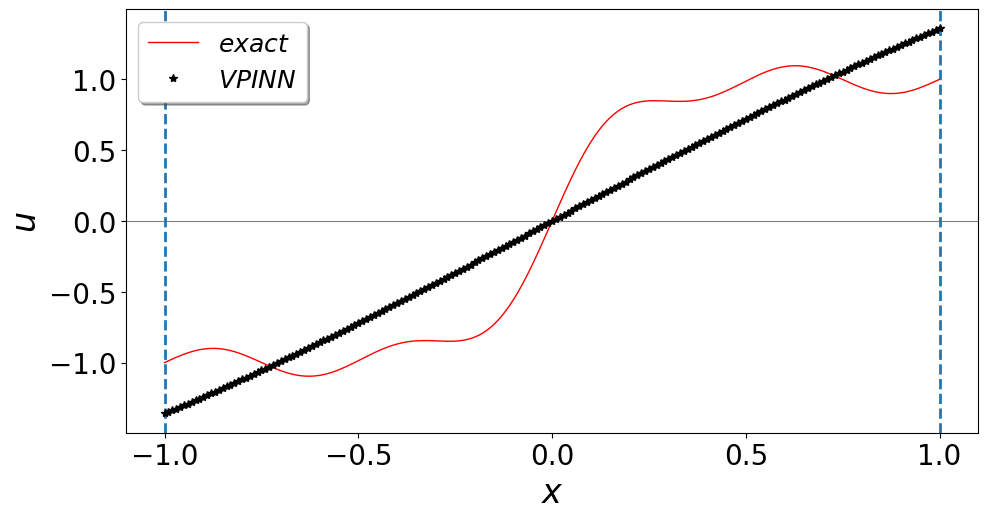

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.83
It: 100, Lossb: 5.368e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.05
It: 200, Lossb: 4.661e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.05
It: 300, Lossb: 5.947e-02, Lossv: 1.500e+01, Losstot:, 1.506e+01, Time: 0.05
It: 400, Lossb: 8.917e-02, Lossv: 1.471e+01, Losstot:, 1.480e+01, Time: 0.05
It: 500, Lossb: 1.066e-01, Lossv: 1.441e+01, Losstot:, 1.452e+01, Time: 0.09
It: 600, Lossb: 7.686e-02, Lossv: 1.412e+01, Losstot:, 1.420e+01, Time: 0.06
It: 700, Lossb: 2.319e-02, Lossv: 1.386e+01, Losstot:, 1.388e+01, Time: 0.05
It: 800, Lossb: 9.415e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.05
It: 900, Lossb: 7.899e-04, Lossv: 1.370e+01, Losstot:, 1.370e+01, Time: 0.05
It: 1000, Lossb: 1.052e-03, Lossv: 1.368e+01, Losstot:, 1.368e+01, Time: 0.06
It: 1100, Lossb: 1.122e-03, Lossv: 1.365e+01, Losstot:, 1.365e+01, Time: 0.05
It: 1200, Lossb: 1.490e-03, Lossv: 1.361e+01, Losstot:, 1.361e+01, Time: 0.0

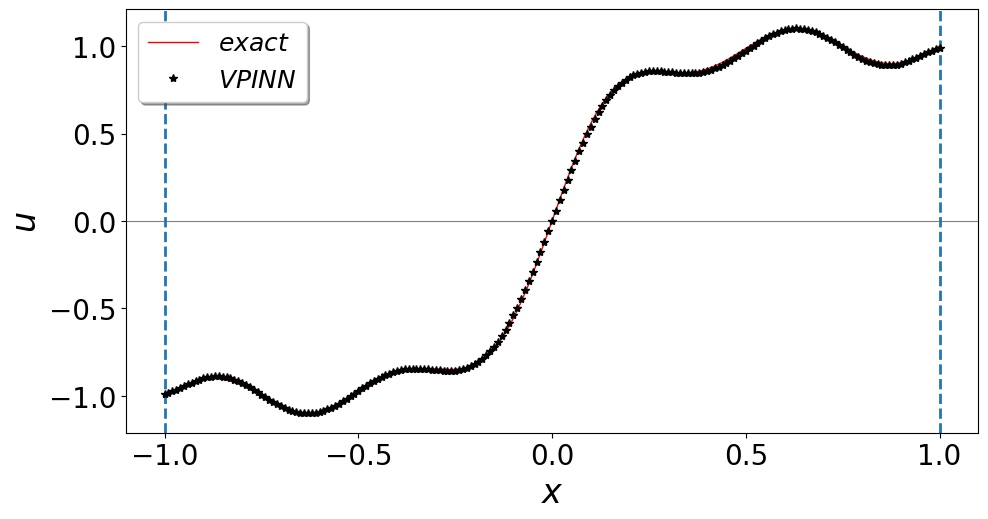

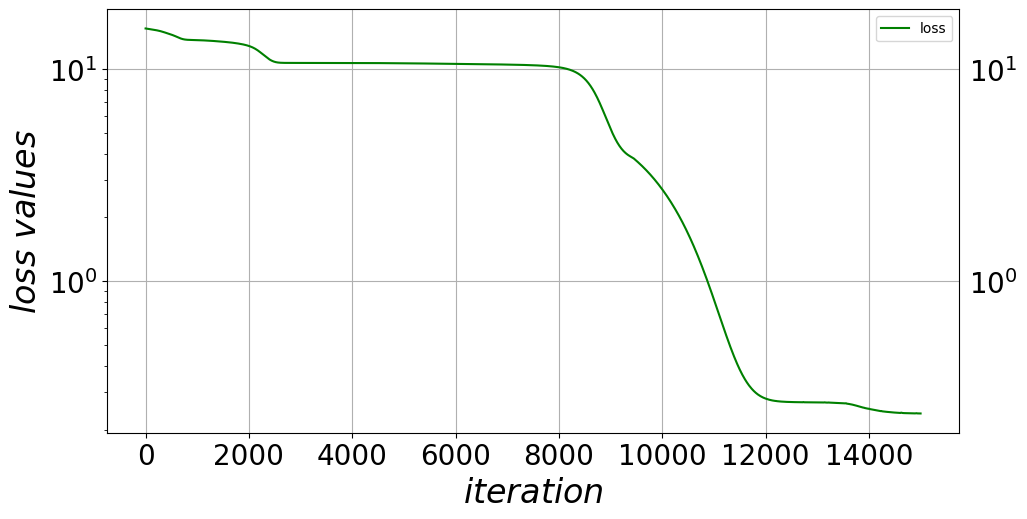

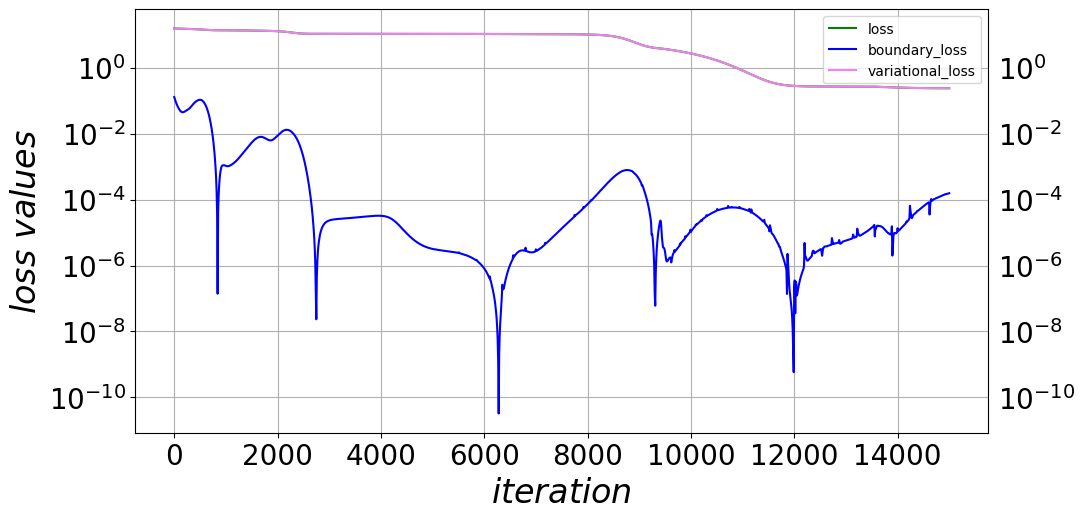

/tmp/ipykernel_19862/1463964288.py:349: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.axvline(x=xc, linewidth=2, ls = '--')


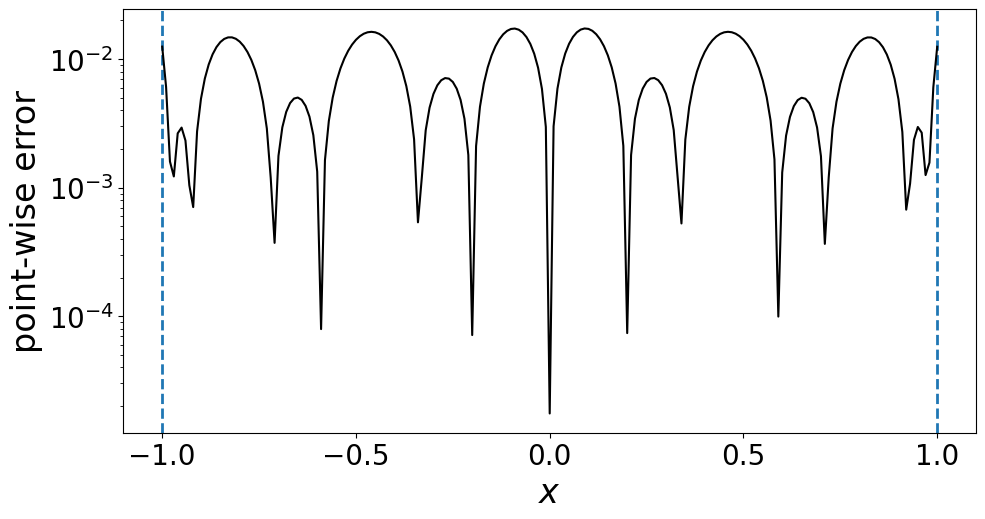

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))


n_quad :  100


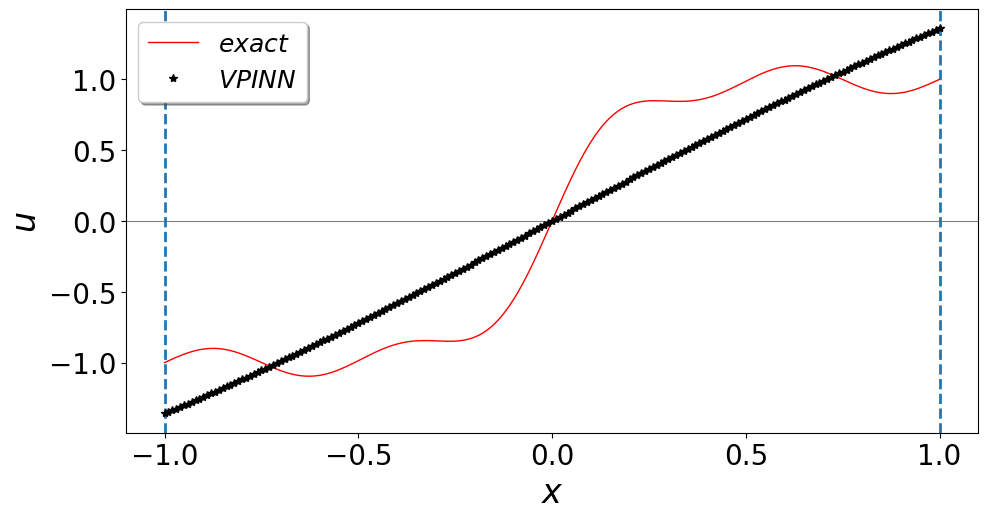

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.76
It: 100, Lossb: 5.469e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.05
It: 200, Lossb: 4.479e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.05
It: 300, Lossb: 5.865e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.05
It: 400, Lossb: 8.943e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.05
It: 500, Lossb: 1.053e-01, Lossv: 1.441e+01, Losstot:, 1.451e+01, Time: 0.05
It: 600, Lossb: 7.394e-02, Lossv: 1.411e+01, Losstot:, 1.419e+01, Time: 0.05
It: 700, Lossb: 2.096e-02, Lossv: 1.385e+01, Losstot:, 1.387e+01, Time: 0.05
It: 800, Lossb: 6.764e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.05
It: 900, Lossb: 7.817e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.05
It: 1000, Lossb: 8.853e-04, Lossv: 1.369e+01, Losstot:, 1.369e+01, Time: 0.05
It: 1100, Lossb: 9.861e-04, Lossv: 1.366e+01, Losstot:, 1.366e+01, Time: 0.04
It: 1200, Lossb: 1.327e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.0

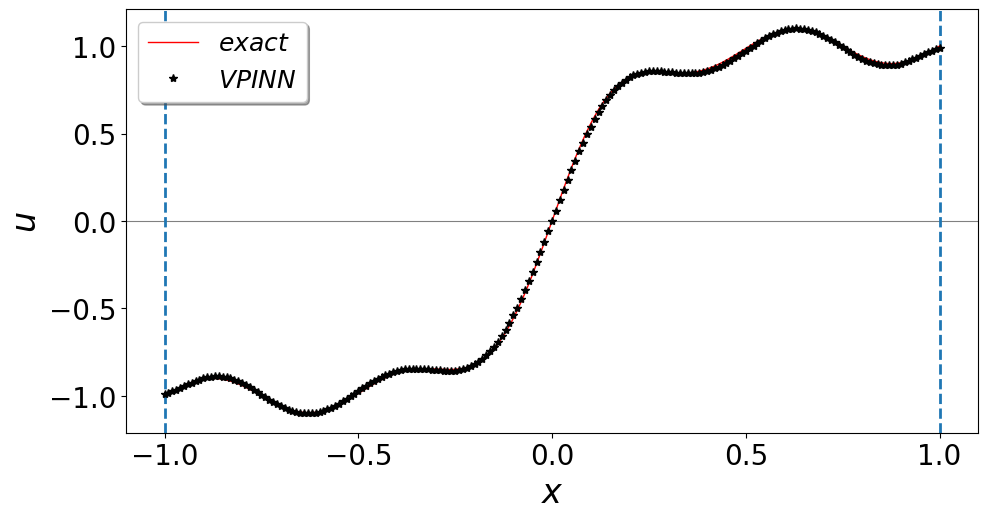

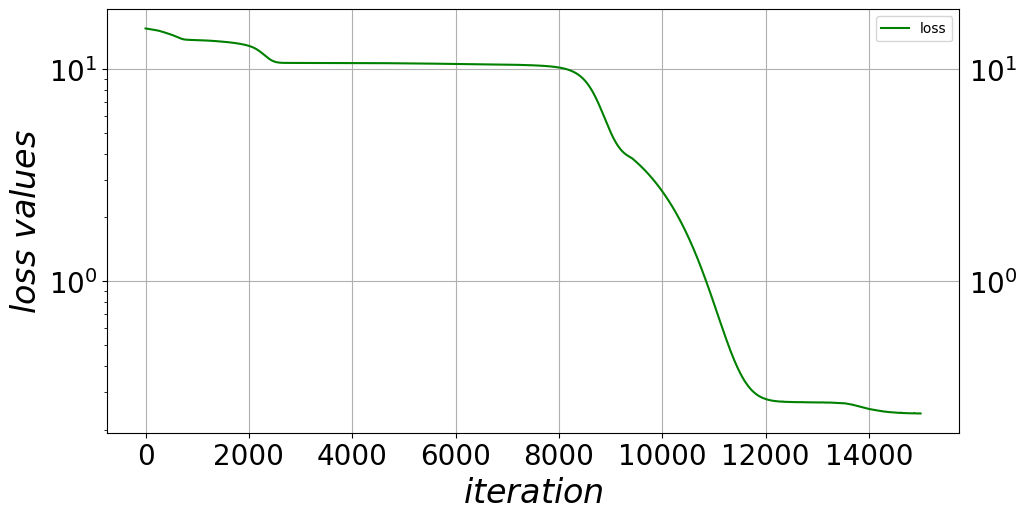

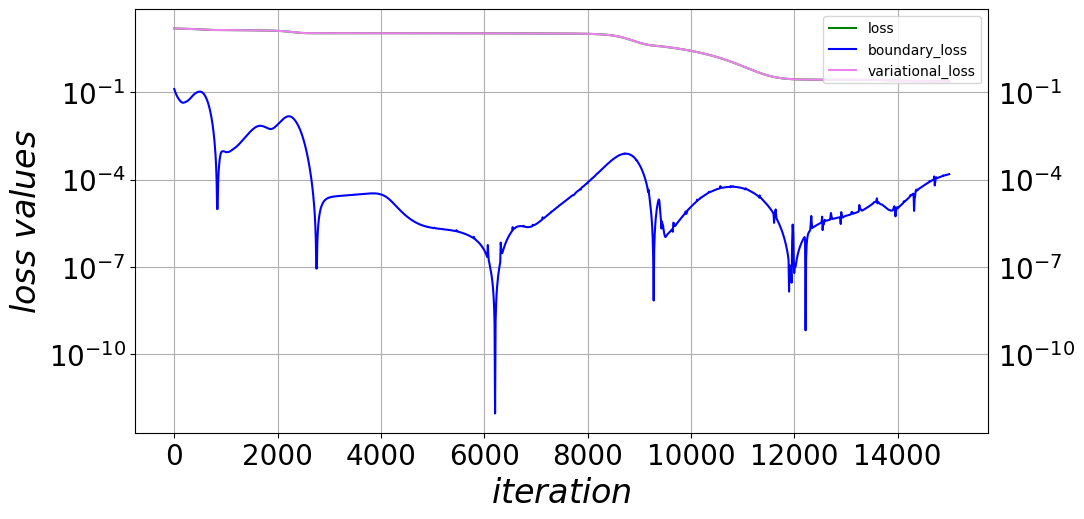

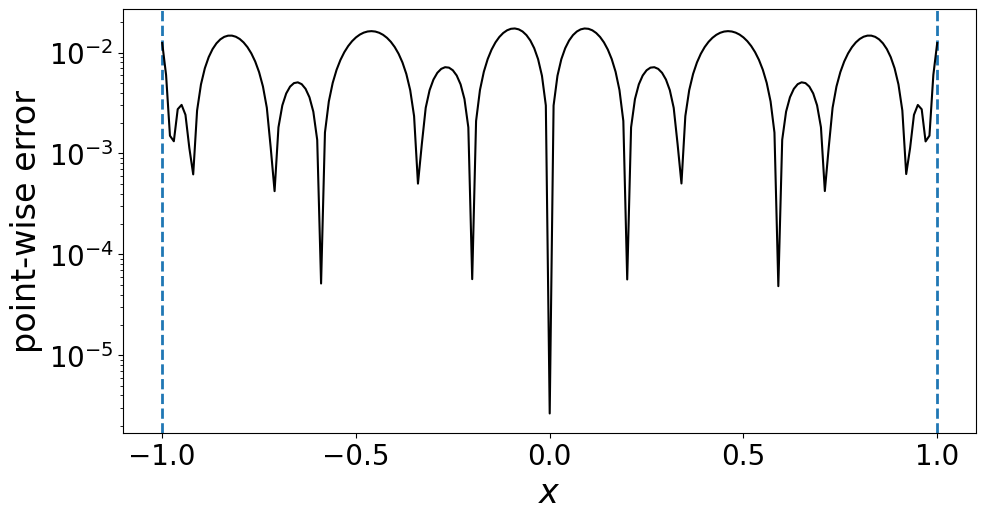

n_quad :  120


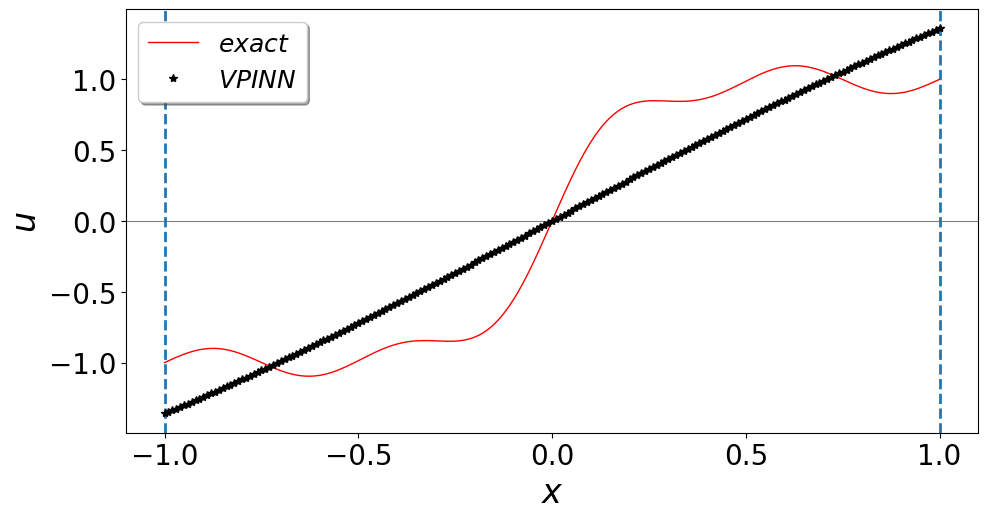

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 1.13
It: 100, Lossb: 5.468e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.05
It: 200, Lossb: 4.480e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.05
It: 300, Lossb: 5.866e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.05
It: 400, Lossb: 8.943e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.05
It: 500, Lossb: 1.053e-01, Lossv: 1.441e+01, Losstot:, 1.451e+01, Time: 0.06
It: 600, Lossb: 7.397e-02, Lossv: 1.411e+01, Losstot:, 1.419e+01, Time: 0.05
It: 700, Lossb: 2.098e-02, Lossv: 1.385e+01, Losstot:, 1.387e+01, Time: 0.05
It: 800, Lossb: 6.783e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.05
It: 900, Lossb: 7.819e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.05
It: 1000, Lossb: 8.862e-04, Lossv: 1.369e+01, Losstot:, 1.369e+01, Time: 0.06
It: 1100, Lossb: 9.875e-04, Lossv: 1.366e+01, Losstot:, 1.366e+01, Time: 0.05
It: 1200, Lossb: 1.328e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.0

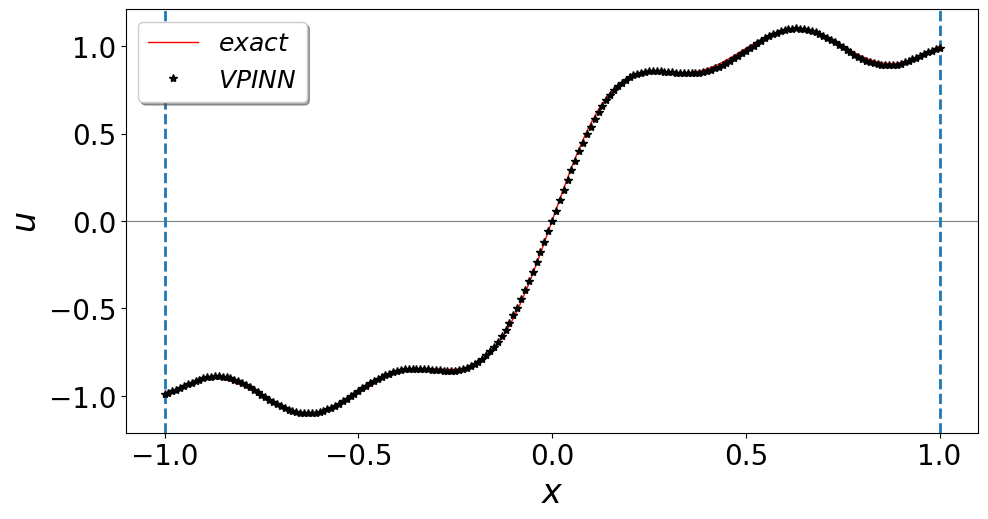

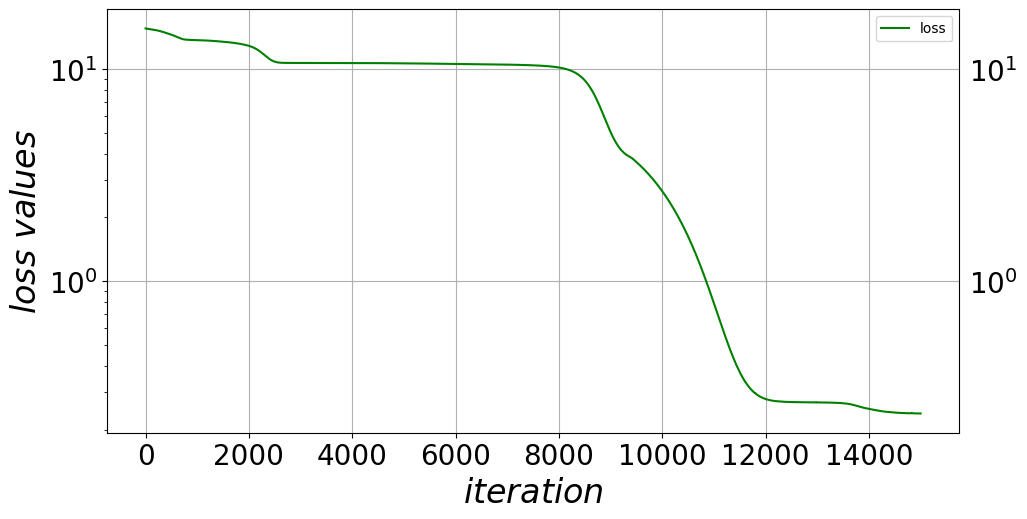

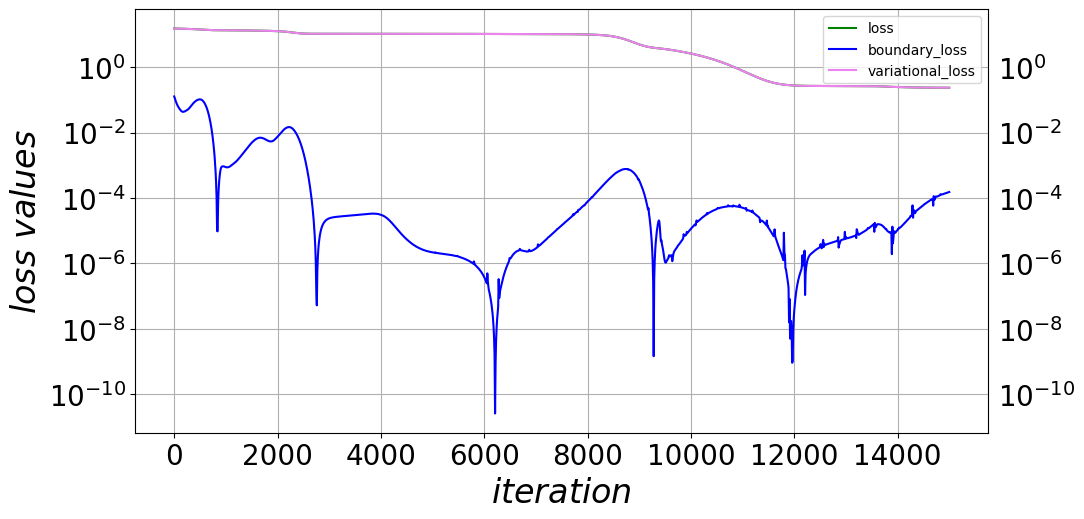

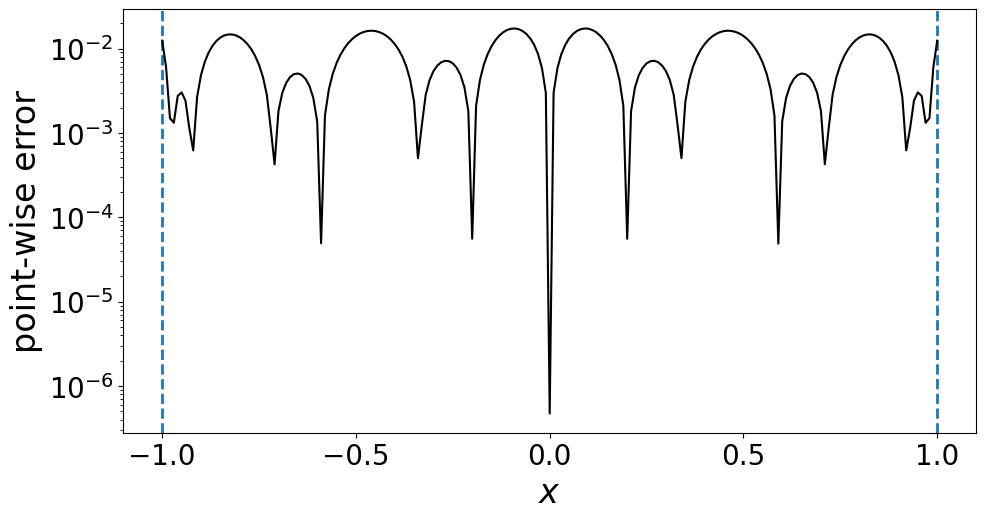

n_quad :  140


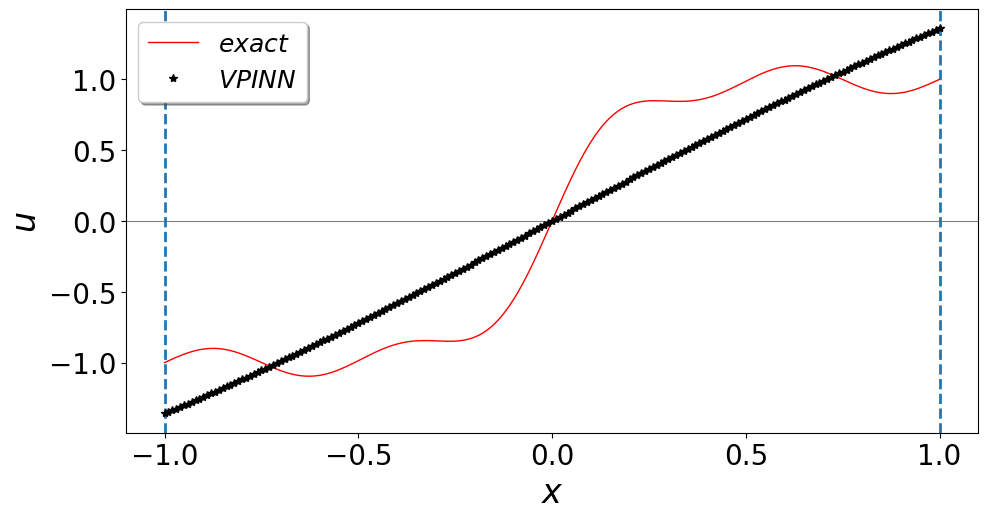

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.78
It: 100, Lossb: 5.424e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.05
It: 200, Lossb: 4.552e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.06
It: 300, Lossb: 5.892e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.05
It: 400, Lossb: 8.939e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.05
It: 500, Lossb: 1.058e-01, Lossv: 1.441e+01, Losstot:, 1.452e+01, Time: 0.06
It: 600, Lossb: 7.503e-02, Lossv: 1.412e+01, Losstot:, 1.419e+01, Time: 0.06
It: 700, Lossb: 2.177e-02, Lossv: 1.385e+01, Losstot:, 1.388e+01, Time: 0.05
It: 800, Lossb: 7.653e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.06
It: 900, Lossb: 7.870e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.05
It: 1000, Lossb: 9.361e-04, Lossv: 1.368e+01, Losstot:, 1.369e+01, Time: 0.05
It: 1100, Lossb: 1.034e-03, Lossv: 1.366e+01, Losstot:, 1.366e+01, Time: 0.05
It: 1200, Lossb: 1.381e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.0

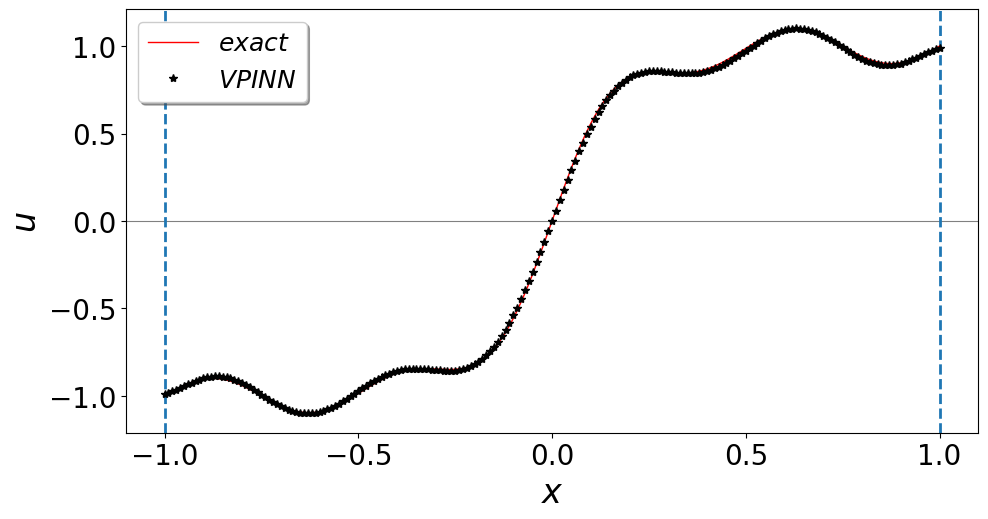

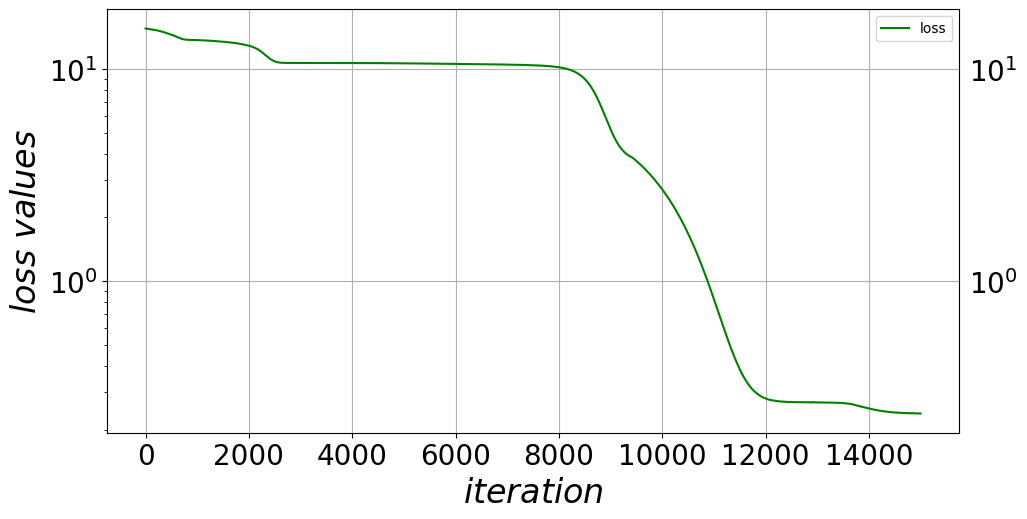

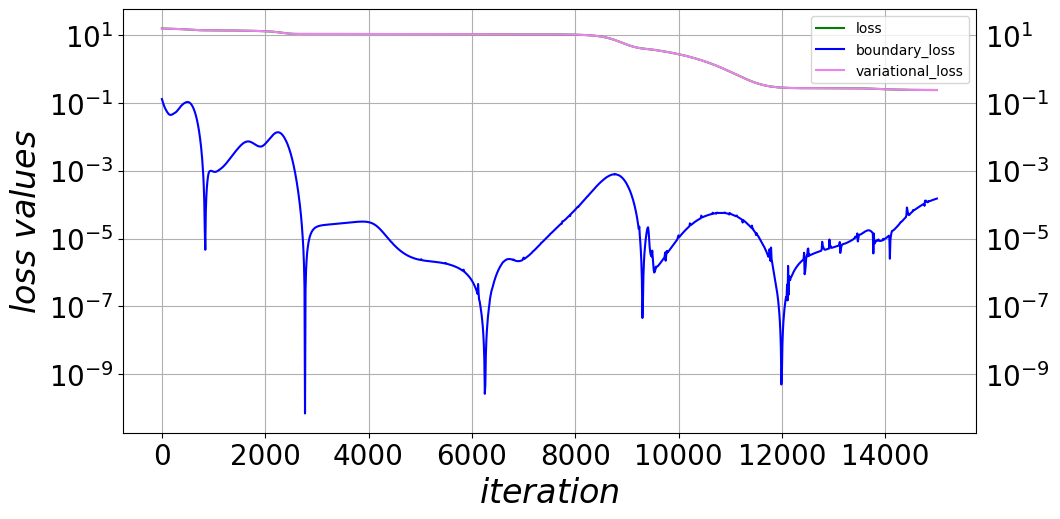

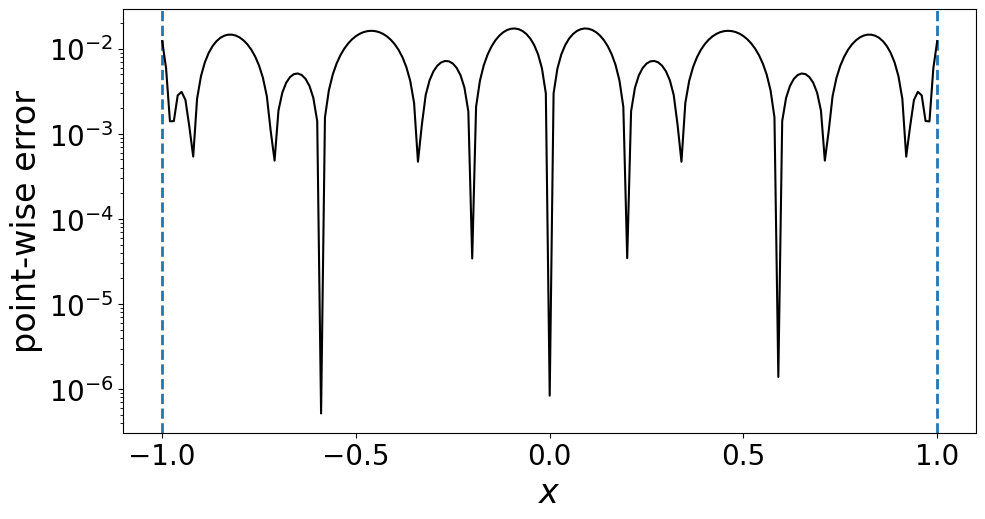

n_quad :  160


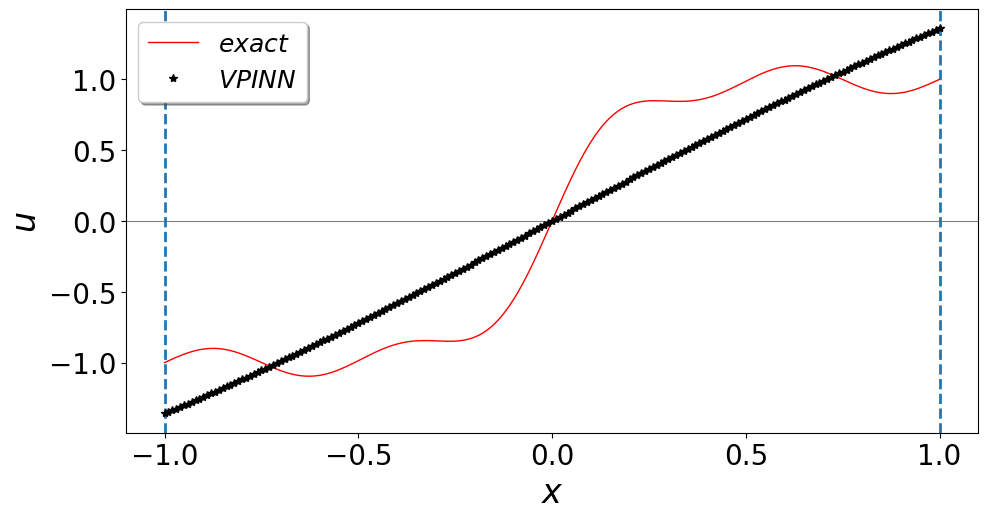

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.99
It: 100, Lossb: 5.406e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.06
It: 200, Lossb: 4.585e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.09
It: 300, Lossb: 5.904e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.07
It: 400, Lossb: 8.935e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.08
It: 500, Lossb: 1.060e-01, Lossv: 1.441e+01, Losstot:, 1.452e+01, Time: 0.06
It: 600, Lossb: 7.554e-02, Lossv: 1.412e+01, Losstot:, 1.419e+01, Time: 0.08
It: 700, Lossb: 2.216e-02, Lossv: 1.385e+01, Losstot:, 1.388e+01, Time: 0.08
It: 800, Lossb: 8.112e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.09
It: 900, Lossb: 7.884e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.09
It: 1000, Lossb: 9.645e-04, Lossv: 1.368e+01, Losstot:, 1.368e+01, Time: 0.08
It: 1100, Lossb: 1.056e-03, Lossv: 1.365e+01, Losstot:, 1.366e+01, Time: 0.11
It: 1200, Lossb: 1.408e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.1

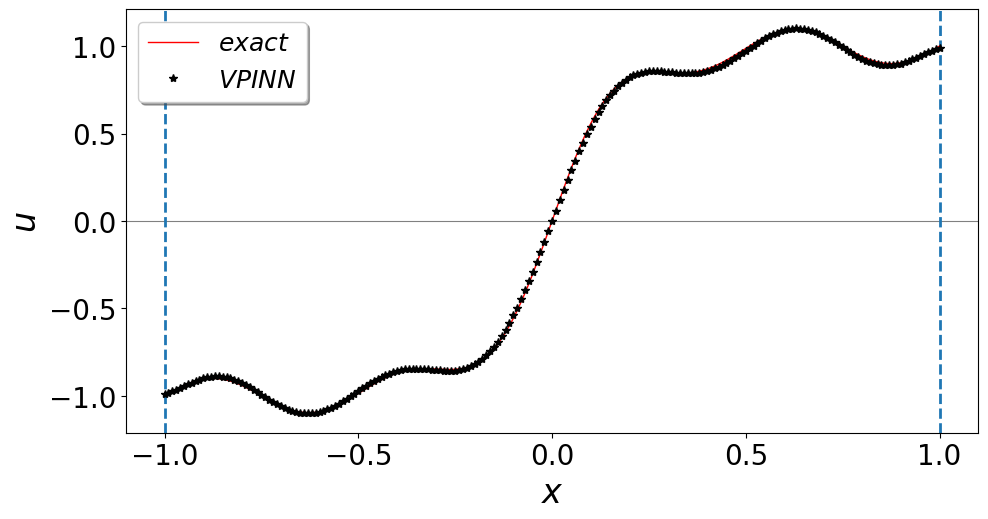

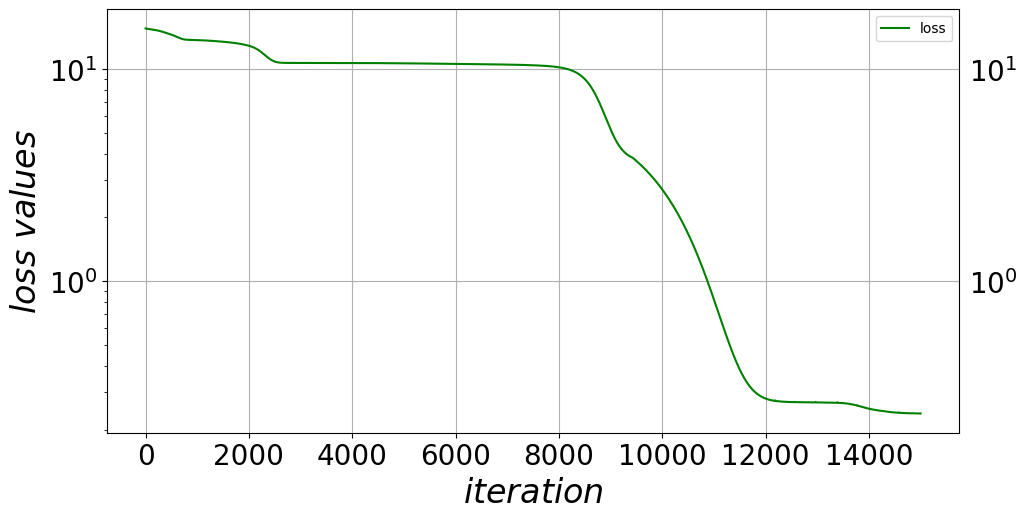

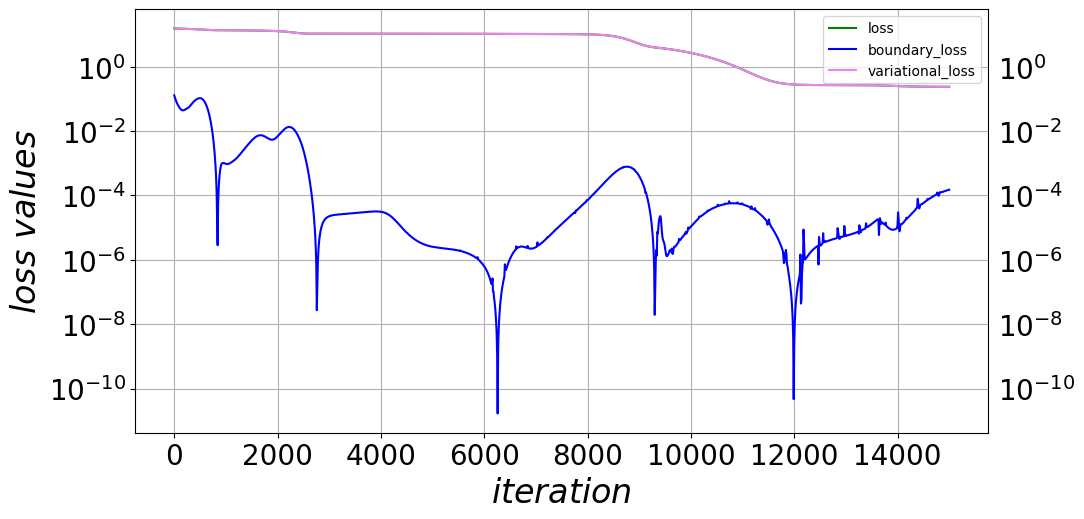

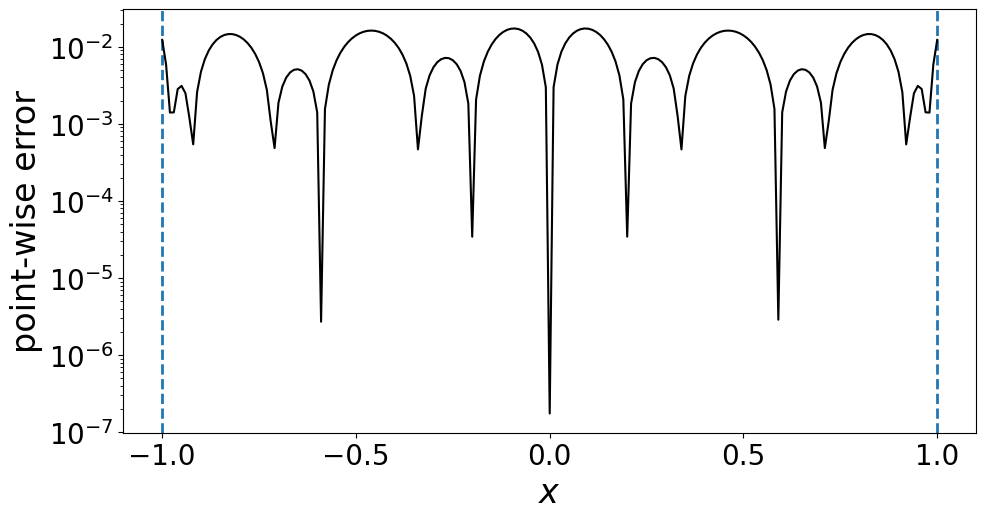

/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:374: RuntimeWarning: invalid value encountered in scalar divide
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/home/mariano/Documenti/test/base/lib/python3.9/site-packages/scipy/special/_orthogonal.py:375: RuntimeWarning: invalid value encountered in scalar divide
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


n_quad :  180


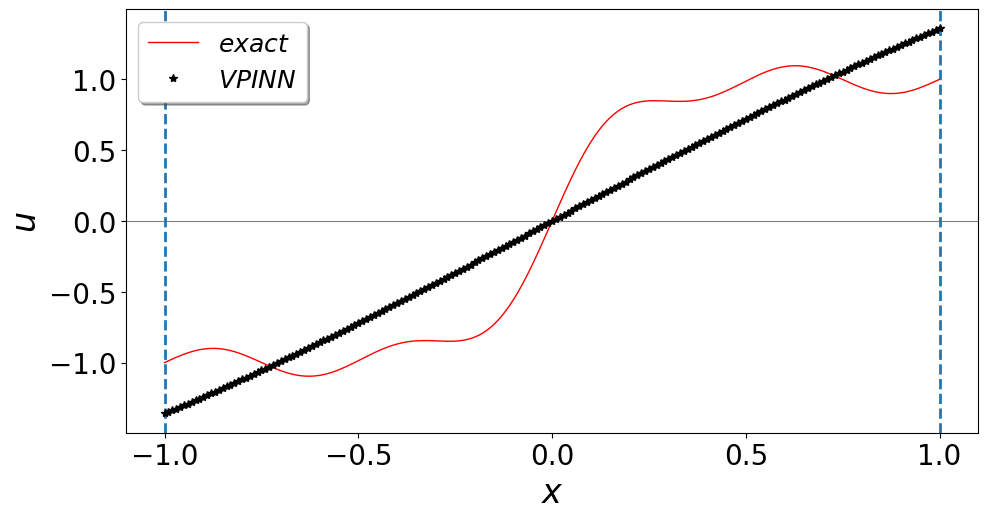

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.74
It: 100, Lossb: 5.423e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.05
It: 200, Lossb: 4.554e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.05
It: 300, Lossb: 5.892e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.05
It: 400, Lossb: 8.939e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.05
It: 500, Lossb: 1.058e-01, Lossv: 1.441e+01, Losstot:, 1.452e+01, Time: 0.07
It: 600, Lossb: 7.505e-02, Lossv: 1.412e+01, Losstot:, 1.419e+01, Time: 0.05
It: 700, Lossb: 2.179e-02, Lossv: 1.385e+01, Losstot:, 1.388e+01, Time: 0.05
It: 800, Lossb: 7.677e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.05
It: 900, Lossb: 7.871e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.06
It: 1000, Lossb: 9.376e-04, Lossv: 1.368e+01, Losstot:, 1.369e+01, Time: 0.06
It: 1100, Lossb: 1.036e-03, Lossv: 1.366e+01, Losstot:, 1.366e+01, Time: 0.05
It: 1200, Lossb: 1.383e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.0

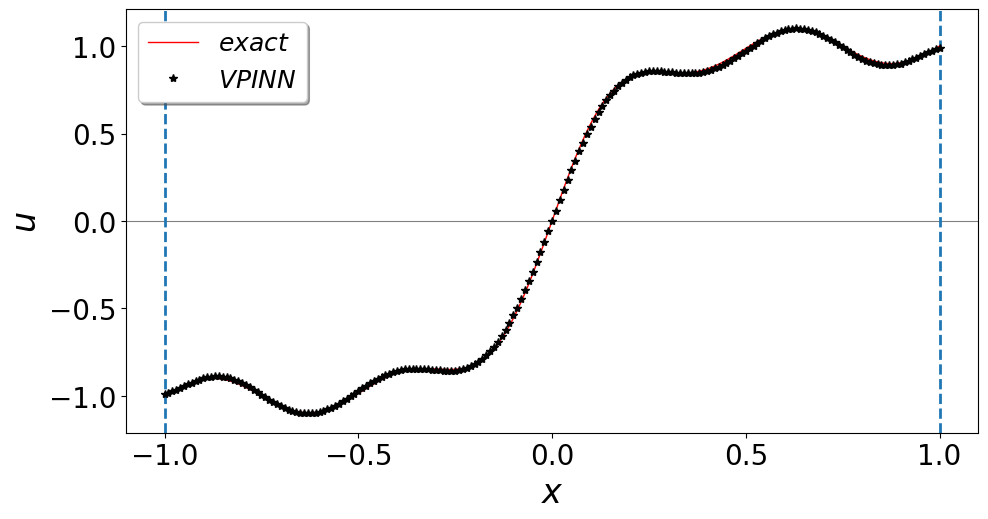

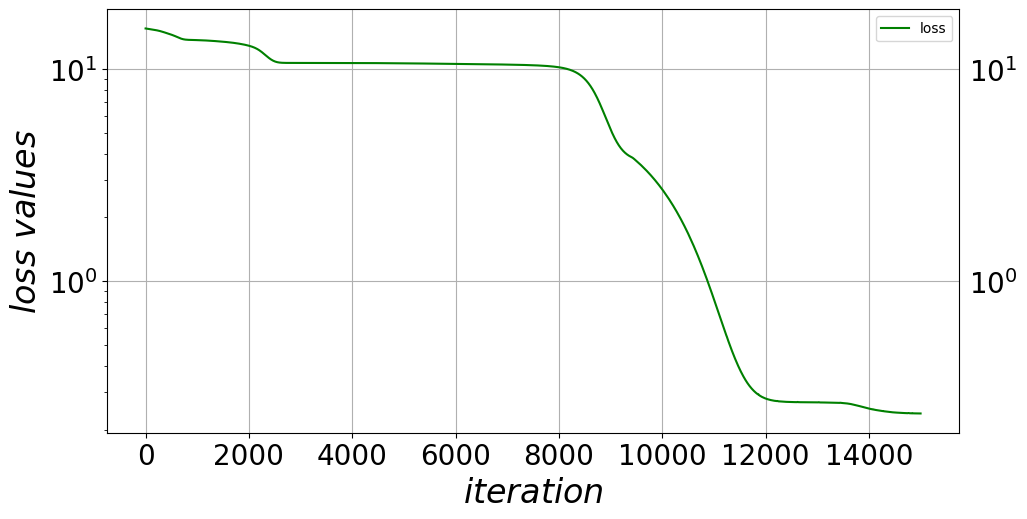

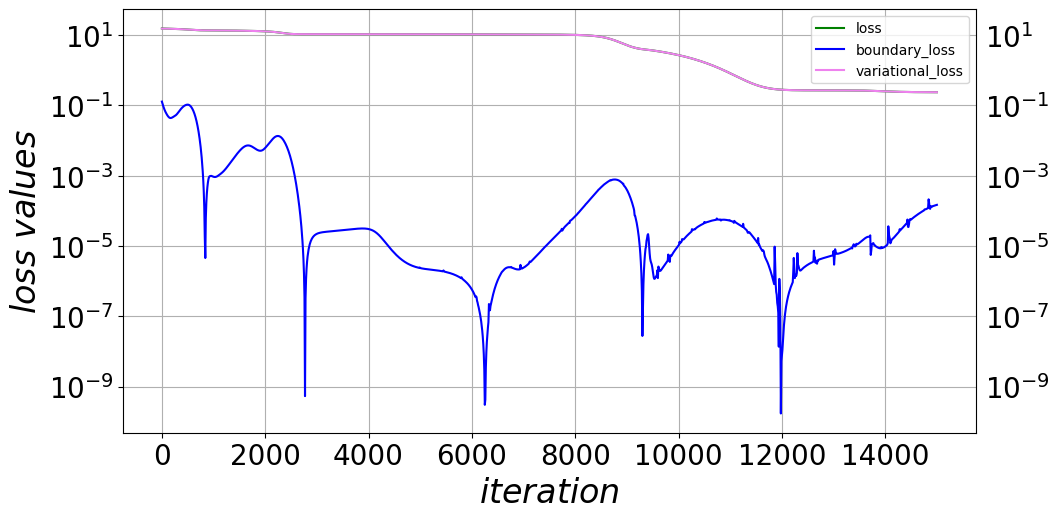

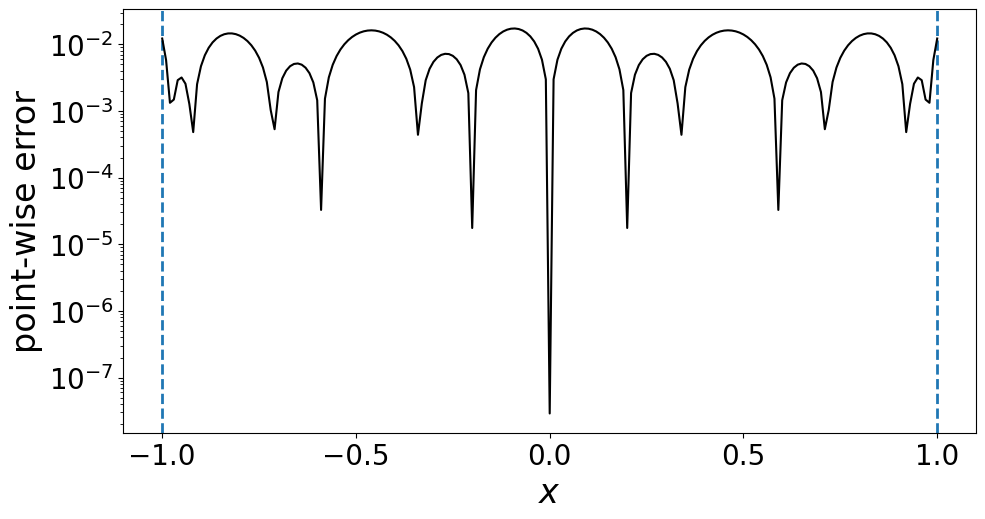

n_quad :  200


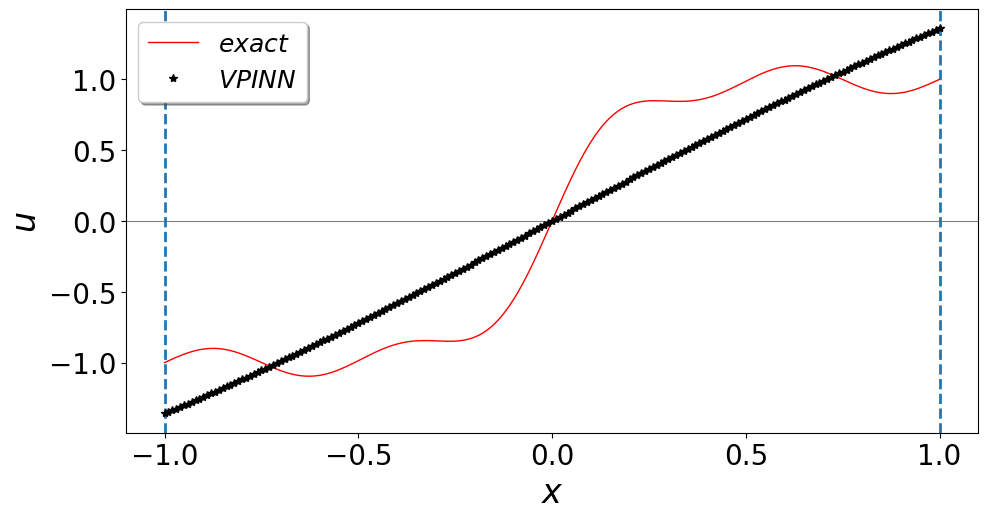

It: 0, Lossb: 1.291e-01, Lossv: 1.540e+01, Losstot:, 1.553e+01, Time: 0.98
It: 100, Lossb: 5.412e-02, Lossv: 1.534e+01, Losstot:, 1.539e+01, Time: 0.08
It: 200, Lossb: 4.574e-02, Lossv: 1.520e+01, Losstot:, 1.525e+01, Time: 0.14
It: 300, Lossb: 5.899e-02, Lossv: 1.499e+01, Losstot:, 1.505e+01, Time: 0.08
It: 400, Lossb: 8.936e-02, Lossv: 1.470e+01, Losstot:, 1.479e+01, Time: 0.09
It: 500, Lossb: 1.059e-01, Lossv: 1.441e+01, Losstot:, 1.452e+01, Time: 0.09
It: 600, Lossb: 7.536e-02, Lossv: 1.412e+01, Losstot:, 1.419e+01, Time: 0.18
It: 700, Lossb: 2.202e-02, Lossv: 1.385e+01, Losstot:, 1.388e+01, Time: 0.14
It: 800, Lossb: 7.948e-04, Lossv: 1.374e+01, Losstot:, 1.374e+01, Time: 0.08
It: 900, Lossb: 7.880e-04, Lossv: 1.371e+01, Losstot:, 1.371e+01, Time: 0.07
It: 1000, Lossb: 9.542e-04, Lossv: 1.368e+01, Losstot:, 1.369e+01, Time: 0.07
It: 1100, Lossb: 1.048e-03, Lossv: 1.366e+01, Losstot:, 1.366e+01, Time: 0.07
It: 1200, Lossb: 1.399e-03, Lossv: 1.362e+01, Losstot:, 1.362e+01, Time: 0.0

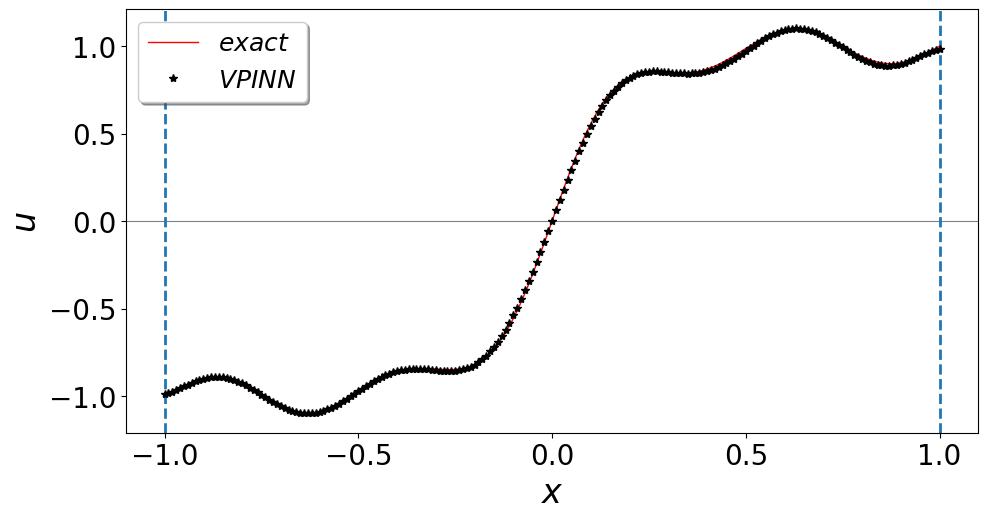

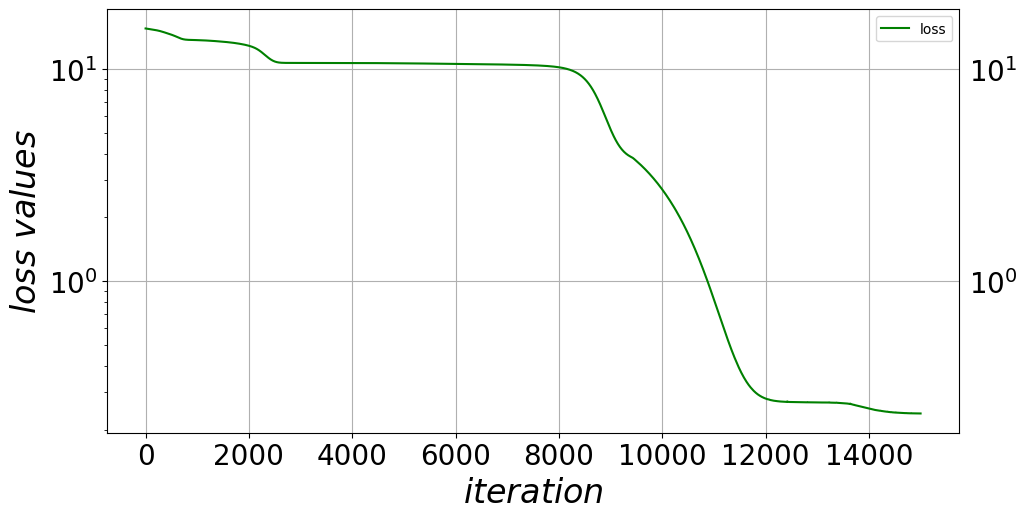

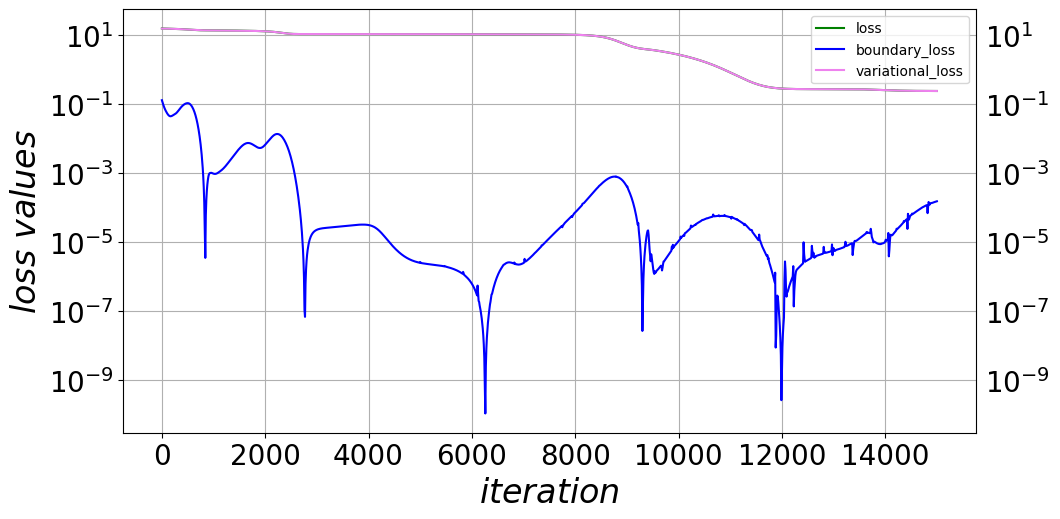

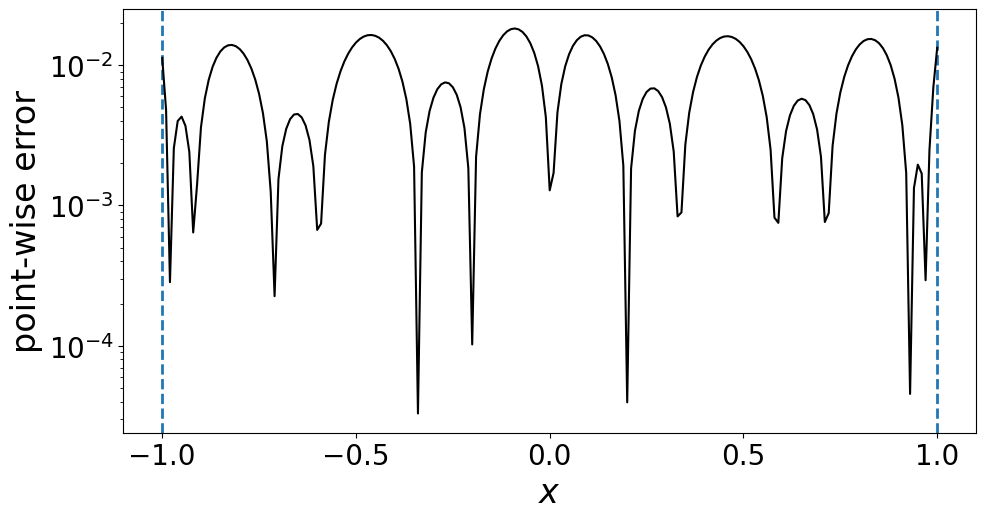

In [89]:
PLOT = 'show'
#only one hidden layer

# incrasing number of elem

n=[80,100,120,140,160,180,200]
H=[]
E_l2=[]
for elem in n:


   # params['n_elements']=elem
   # params['n_test']=params['n_elements']*[N_tests]
   # os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

    params['n_quad']=elem

    model = VPINN(pb,params,53,None)
    print("n_quad : ",elem)
    model.plot_predict(PLOT)

    loss_his = model.train(params['Opt_Niter'])
    
    H.append(1.0/elem)

    result1 =sqrt(quad(lambda x :(model.custom_call(x)-pb.u_exact(x))**2,-1, 1)[0])



    E_l2.append(result1)
   




    model.plot_predict(PLOT)
    model.plot_loss_history(PLOT)    
    model.plot_pointwise_error(PLOT)



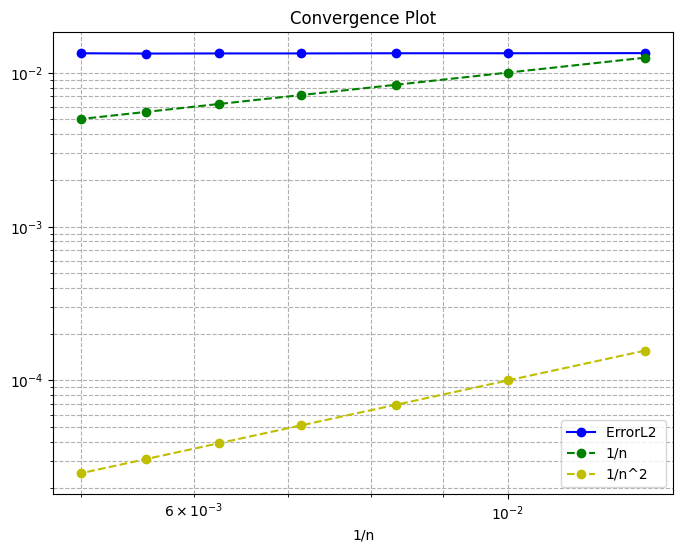

[0.013382494332513012, 0.013355613684036271, 0.013354745875832852, 0.013319850281524815, 0.013321614070793375, 0.013296491393304823, 0.013352944079449019]


In [90]:
H=np.asarray(H)
plt.figure(figsize=(8, 6))
plt.loglog(H, E_l2, marker='o', linestyle='-', color='b', label='ErrorL2 ')
plt.loglog(H, H, marker='o', linestyle='--', color='g', label='1/n')
plt.loglog(H, H**2, marker='o', linestyle='--', color='y', label='1/n^2')
plt.xlabel('1/n')
plt.title('Convergence Plot')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()
print(E_l2)

In [91]:
print(params['NN_struct'][0])
input=tf.constant([1.0],dtype=tf.float64)
print(input)

#the input must be a tensor of two dims(col)
#if you inherit from tf.keras model and you init like you did you can view the structure of the the net if you type:
print(model.NN(input))

print(model.custom_call(1.0))


1
tf.Tensor([1.], shape=(1,), dtype=float64)
tf.Tensor([[0.98659656]], shape=(1, 1), dtype=float64)
0.9865965571945763
